# Adversarial attacks<a id='adv'></a>

Note there are few different things we can try:
- rand v true
- test v train (note: no point testing rand labels for test set)
- L_2 v L_inf

**only test L2 with true labels on test set**

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
%load_ext autoreload
%autoreload 2

import time
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from spectral_adversarial_regularization import dl_utils
from spectral_adversarial_regularization import adversarial as ad
from spectral_adversarial_regularization.models import *

%matplotlib inline

In [3]:
from get_cifar10 import get_cifar10_dataset

# Load dataset
n_samps = 50000
num_classes = 10

# each value: Xtr, Ytr, Xtt, Ytt
data = {
    'true': get_cifar10_dataset(0, n_samps=n_samps),
    'rand': get_cifar10_dataset(100, n_samps=n_samps)
}

data_small = {
    'true': (data['true'][0][:1000], data['true'][1][:1000], data['true'][2][:1000], data['true'][3][:1000]),
    'rand': (data['rand'][0][:1000], data['rand'][1][:1000], data['rand'][2][:1000], data['rand'][3][:1000])
}

In [42]:
def get_adv_acc_curve(X, Y, save_dir, arch, eps_list, order=2):
    adv_accs = np.zeros(len(eps_list))
    acc = dl_utils.build_graph_and_predict(X, save_dir, arch=arch, Y=Y)
    for i, eps in enumerate(eps_list):
        adv_accs[i] = ad.test_net_against_adv_examples(X, Y, save_dir, arch, eps=eps, order=order)
    return acc, adv_accs

def get_all_curves(data, arch_name, models, dataset):
    assert dataset == 'train' or dataset == 'test'
    
    results = {'true':{}, 'rand':{}}
    main_dir = 'save_weights_n50000_%s_tightsn'%(arch_name)
    for i in results.keys():
            
        if dataset == 'train':
            X, Y = data[i][0], data[i][1]
        else:
            if i == 'rand':
                continue
            X, Y = data[i][2], data[i][3]
            
        save_dir = 'save_weights_n50000_%s/%s_%s/'%(arch_name, arch_name, i)
        results[i][arch_name] = get_adv_acc_curve(X, Y, save_dir, models['default'], eps_list, order=2)
        
        for f in os.listdir(main_dir):
            if i in f:
                name = f.replace('_rand', '').replace('_true', '')
                save_dir = os.path.join(main_dir, f)
                results[i][name] = get_adv_acc_curve(X, Y, save_dir, models[f.split('_')[2]], eps_list, order=2)
            
    return results

def sort_func(fname):
    if 'wd' not in fname:
        return (-1, fname)
    return (float(fname.split('wd')[1]), fname)

def plot_adv_curves(results, arch_name):
    plt.figure(figsize=(10, 7))
    plt.title(arch_name)
    for label in sorted(results['true'], key=sort_func):
        plt.plot(eps_list, results['true'][label][0]-results['true'][label][1],
                 label='%s with acc %.2f'%(label, results['true'][label][0]))
    plt.legend()
    plt.ylabel('Drop in accuracy on adversarial examples')
    plt.xlabel('eps (amount of perturbation)')
    plt.grid()
    plt.show()

In [5]:
eps_list = np.logspace(-1, 1, 9)

In [14]:
arch_name = 'alexnet'

models = {
    'default': alexnet.alexnet,
    'sn': alexnet_tightsn.alexnet_sn,
    'sar': alexnet_tightsn.alexnet_sar
}

results = get_all_curves(data_small, arch_name, models, 'test')

INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.75 (1.200 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.74 (1.283 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.73 (1.342 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.70 (1.597 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.60 (1.387 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet/alexnet_true/checkpoints/epoch34
Acc on adv examples: 0.47 (1.579 s elapsed)
INFO:tensorflow

Acc on adv examples: 0.77 (2.706 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpoints/epoch356
Acc on adv examples: 0.77 (3.463 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpoints/epoch356
Acc on adv examples: 0.74 (2.888 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpoints/epoch356
Acc on adv examples: 0.69 (2.755 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpoints/epoch356
Acc on adv examples: 0.55 (2.740 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpoints/epoch356
Acc on adv examples: 0.35 (3.573 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_alexnet_tightsn/alexnet_true_sar_wd0.0004/checkpo

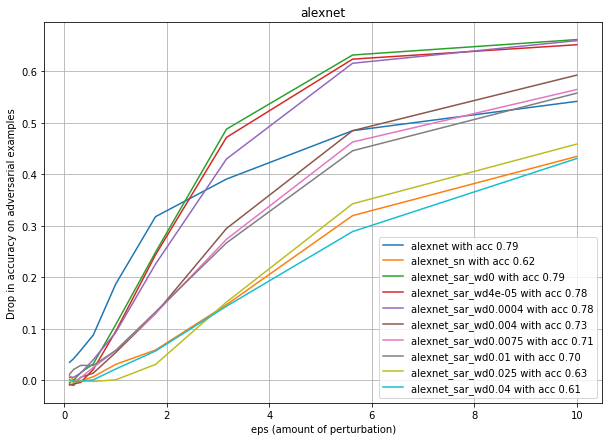

In [43]:
plot_adv_curves(results, arch_name)

In [44]:
arch_name = 'inception'

models = {
    'default': inception.inception,
    'sn': inception_tightsn.inception_sn,
    'sar': inception_tightsn.inception_sar
}

results = get_all_curves(data_small, arch_name, models, 'test')

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.74 (8.239 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.70 (8.099 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.65 (10.815 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.55 (7.804 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.47 (7.599 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception/inception_true/checkpoints/epoch49
Acc on adv examples: 0.41 (7.5

INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on adv examples: 0.83 (11.446 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on adv examples: 0.82 (12.259 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on adv examples: 0.81 (13.021 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on adv examples: 0.77 (12.620 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on adv examples: 0.67 (13.220 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.004/checkpoints/epoch289
Acc on 

Acc on adv examples: 0.12 (11.533 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
Acc on adv examples: 0.82 (11.238 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
Acc on adv examples: 0.80 (13.451 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
Acc on adv examples: 0.80 (12.835 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
Acc on adv examples: 0.78 (11.399 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_inception_tightsn/inception_true_sar_wd0.1/checkpoints/epoch499
Acc on adv examples

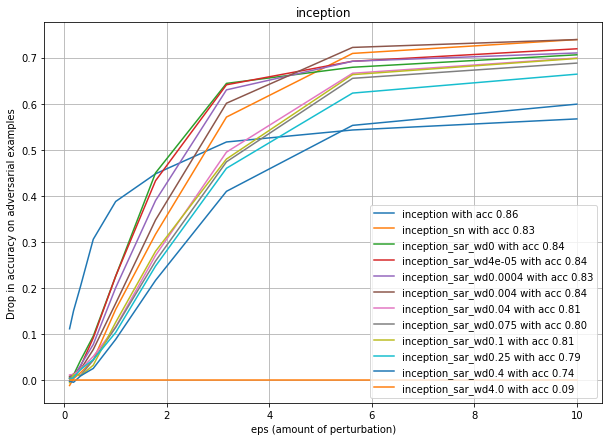

In [45]:
plot_adv_curves(results, arch_name)

In [46]:
arch_name = 'vgg'

models = {
    'default': vgg.vgg,
    'sn': vgg_tightsn.vgg_sn,
    'sar': vgg_tightsn.vgg_sar
}

results = get_all_curves(data_small, arch_name, models, 'test')

INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.66 (3.883 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.65 (3.686 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.61 (3.485 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.55 (3.624 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.46 (3.259 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_true/checkpoints/epoch37
Acc on adv examples: 0.39 (3.624 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg/vgg_t

INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.004/checkpoints/epoch499
Acc on adv examples: 0.55 (8.078 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.004/checkpoints/epoch499
Acc on adv examples: 0.50 (5.799 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.004/checkpoints/epoch499
Acc on adv examples: 0.42 (6.364 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.004/checkpoints/epoch499
Acc on adv examples: 0.29 (9.038 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.004/checkpoints/epoch499
Acc on adv examples: 0.18 (6.345 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sar_wd0.04/checkpoints/epoch499
INFO:tensorflow:Restoring parameters from save_weights_n50000_vgg_tightsn/vgg_true_sa

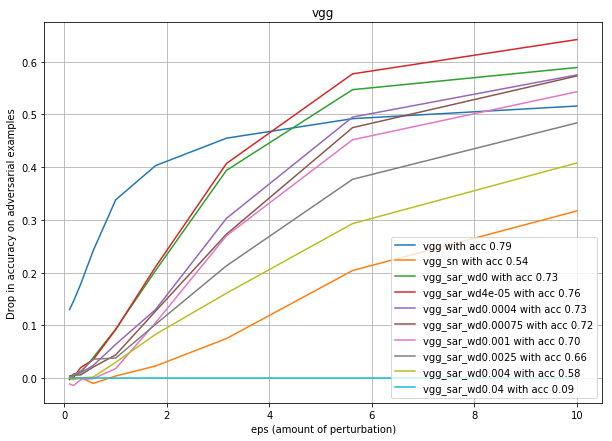

In [47]:
plot_adv_curves(results, arch_name)